In [1]:
import numpy as np 
import pickle
# Matplotlip
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
%matplotlib inline
# Pandas
import pandas as pd
from pandas import Series, DataFrame
# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.pipeline import Pipeline
# scipy
from scipy.fftpack import fft
from scipy import integrate 
from scipy.optimize import root_scalar

In [8]:
import numpy as np 
import pickle
# Matplotlip
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
%matplotlib inline
# Pandas
import pandas as pd
from pandas import Series, DataFrame
# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.pipeline import Pipeline
# scipy
from scipy.fftpack import fft
from scipy import integrate 
from scipy.optimize import root_scalar

class units:
    # Energy and mass
    eV    = 1.
    keV   = 1.e3
    MeV   = 1.e6
    GeV   = 1.e9
    TeV   = 1.e12
    PeV   = 1.e15
    kg    = 5.62e35*eV
    grams = 0.001*kg
    
    # Length and time
    m     = 5.076e6
    meter = m
    km    = 1000*m
    cm    = 0.01*m
    nm    = 1.e-9*m
    fm    = 1.e-15*m
    AU    = 1.4960e11*m
    pc    = 30.857e15*m
    kpc   = 1.e3*pc
    Mpc   = 1.e6*pc
    Gpc   = 1.e9*pc
    ly    = 9460730472580800*m  # light year
    sec   = 1.523e15
    hours = 3600*sec
    days  = 24*hours
    yrs   = 365*days,
    Hz    = 1./sec
    kHz   = 1.e3*Hz
    MHz   = 1.e6*Hz
    GHz   = 1.e9*Hz
    
    # Various astrophysical constants
    GN    = 6.708e-39/1e18  # eV^-2, Newton's constant
    MPl   = 1.22093e19*GeV   # Planck mass, PDG 2013
    Msun  = 1.989e30*kg
    Rsun  = 6.9551e8*meter
    
    # cosmology
    h       = 0.688                          # according to Planck, see Wikipedia; HE97
    H0      = h * 100. * km / sec/ Mpc       # Hubble parameter
    rho_c0  = 3. * H0**2/(8. * np.pi * GN)   # critical density today, Kolb Turner eq. (3.14)
    Omega_m = 0.14 / h**2                    # total matter density
    Omega_vac = 1 - Omega_m
    RH = 1/H0                                # Hubble radius 
    
    # particle physics
    alpha_em = (1./137.035999139)            # electromagnetic fine structure constant (PDG 2018)
    m_e      = 0.5109989461 * MeV            # electron mass (PDG 2018)

import warnings
warnings.filterwarnings("ignore")

# Routines necessary to read the events

In [3]:
def autocorrelation(vec):
    return np.array([np.mean(np.conj(vec) * np.roll(vec, n))/(np.mean(vec)**2) for n in range(len(vec))])

def fit_power_spectrum(f_range, spectrum, alpha = 1e-13, degree = 10, strategy = 'ridge'):
    if (not strategy == 'ridge') and (not strategy == 'lasso') and (not strategy == 'none'):
        print('Unknown Strategy, proceeds with default parameters!')
        strategy = 'ridge'
    if strategy == 'lasso':
        lr = linear_model.Lasso(alpha = alpha)
    elif strategy == 'none':
        lr = LinearRegression()
    else:
        lr = linear_model.Ridge(alpha = alpha) 
    pf = PolynomialFeatures(degree = degree)
    fs = (f_range / np.mean(f_range)).reshape((-1, 1))
    frp = pf.fit_transform(fs)
    spectrum = np.log(spectrum)
    spectrum = spectrum.reshape((-1, 1))
    lr.fit(frp, spectrum)
    return spectrum, (lr.predict(frp)).reshape((-1,))

def read_events_and_metadata(filename, f_range = True, autocorr_power = False, autocorr_spectrum = False, 
                             fits = {'strategy': ['lasso', 'ridge'], 'd': [25, 25], 'alpha': [0.05, 1e-4]}):
    nfits = len(fits['strategy'])
    if (not len(fits['d']) == nfits) or (not len(fits['alpha']) == nfits):
        print('The arrays lengths in the fits dictionary are inconsistent, proceed without fitting')
        nfits = 0
    metadata_columns = ['M', 'x_diff_ism', 'DS', 'DL', 'DLS', 'zL', 'y', 'Dsc']
    metadata = np.zeros((100, len(metadata_columns)))
    metadata = DataFrame(metadata, columns = metadata_columns)
    event_columns = ['omega_range', 'spect_table']
    u = units()
    with open(filename.format(), 'rb') as f:
        summary = pickle.load(f)
    all_events = {}
    for num, event in enumerate(summary):
        for ent in metadata_columns:
            metadata.iloc[num][ent] = event[ent]
        record = {}
        record = {el: event[el] for el in event_columns}
        record = DataFrame(record)
        record['power'] = abs(record['spect_table'])**2
        record.omega_range = record.omega_range / u.GHz
        if f_range:
            record['f_range'] = record['omega_range'] / 2 / np.pi
        if autocorr_power:
            record['autocorr_power'] = autocorrelation(record['power'])
        if autocorr_spectrum:
            record['autocorr_spectrum'] = autocorrelation(record['spect_table'])
        if nfits > 0:
            for i, strat in enumerate(fits['strategy']):
                lgp, pred = fit_power_spectrum(np.array(record.f_range), np.array(record.power), alpha = fits['alpha'][i], degree = fits['d'][i], strategy = strat)
                if i == 0:
                    record['log_power'] = lgp
                colname_f = 'fit' + str(i)
                record[colname_f] = pred
                colname_t = 'transfer' + str(i)
                record[colname_t] = record['log_power'] - record[colname_f]
        all_events[num] = record
    metadata.M = metadata.M/ u.Msun
    metadata.x_diff_ism = metadata.x_diff_ism / u.cm
    metadata.DS = metadata.DS / u.Gpc
    metadata.DL = metadata.DL / u.Gpc
    metadata.DLS = metadata.DLS / u.Gpc
    metadata.Dsc = metadata.Dsc / u.kpc
    number_of_rows = len(all_events)
    metadata = metadata.loc[:number_of_rows-1]
    return metadata, all_events

# Routines for event analysis 

In [17]:
sf = ScalarFormatter()
sf.set_scientific(True)
sf.set_powerlimits((-2, 2))

#########################################################################################################################################
#########################################################################################################################################
########## AUXILIARY ROUTINES ###########################################################################################################

round_to_1 = lambda x: round(x, -int(np.floor(np.log10(abs(x)))))

round_to_2 = lambda x: round(x, 1-int(np.floor(np.log10(abs(x)))))

def running_average(x, steps):
    return np.convolve(x, np.ones(steps), mode = 'same')/steps  

def rE(M, DL, DS, z = None):
    u = units()
    if z == None:
        z = dist_to_z(DL)
    return np.sqrt(4 * u.GN * M * DL * (1+z) * (DS - DL)/DS)


def lens_time_delay(M, DL, DS, y, z):
    xE = rE(M, DL, DS, z)
    thetaE = xE / DL
    DLS = DS - DL
    beta =  y * thetaE
    theta_p = 0.5 * (beta + np.sqrt(beta**2 + 4 * thetaE**2))
    theta_m = 0.5 * (beta - np.sqrt(beta**2 + 4 * thetaE**2)) 
    return np.abs(DL * DS / DLS * (0.5 * (theta_p - beta)**2 - thetaE**2 * np.log(np.abs(theta_p)) 
                                   - 0.5* (theta_m - beta)**2 + 
                                   thetaE**2 * np.log(np.abs(theta_m))))

def fourier_transform(frequencies, spectrum):
    u = units()
    epsilon = 1e-8
    df = np.real((frequencies[-1] - frequencies[0]) / (len(frequencies) - 1)) * u.GHz
    dt = np.real(1 / (frequencies[-1]*u.GHz - frequencies[0]*u.GHz))
    t_range = np.arange(-1/2/df, (1+ epsilon)/2/df, dt) / u.sec
    transform = np.abs(fft(spectrum))**2
    return t_range, transform

def find_sigmas(X, y, width = 1, log_input = False, a_input = [.1, .5, 1., 4.], dim_input = [2, 5], strategy = 'ridge'):
    if not len(X) == len(y):
        print('Dimensions do not match!')
        return None
    if (not strategy == 'lasso') and (not strategy == 'none') and (not strategy == 'ridge'):
        print('Unknown strategy, uses default')
        strategy = 'ridge'
    ensemble = len(a_input) * len(dim_input)
    start = len(X)//2
    Xshort = X[start:]
    if log_input:
        yshort = y[start:]
    else:
        yshort = np.log(y[start:])
    ## Rescale Xshort:
    Xshort = Xshort/np.mean(Xshort)
    sigmas = []
    all_indices = range(len(Xshort))
    for i in range(len(Xshort)):
        if i - width < 0 or i+width > len(Xshort):
            sigmas.append(0.0)
            continue
        else:
            peak_indices = range(i - width, i+width, 1)
            fit_indices = sorted(list(set(all_indices) - set(peak_indices)))
            X_transformed = Xshort[fit_indices].reshape((-1, 1))
            y_transformed = yshort[fit_indices].reshape((-1, 1))
            significance = 0.0
            for a in a_input:
                for d in dim_input:
                    if strategy == 'lasso':
                        model = Pipeline(steps = [('pf', PolynomialFeatures(degree = d)), 
                                                    ('linreg', linear_model.Lasso(alpha = a))])
                    elif strategy == 'ridge':
                        model = Pipeline(steps = [('pf', PolynomialFeatures(degree = d)), 
                                                  ('linreg', linear_model.Ridge(alpha = a))])
                    else:
                        model = Pipeline(steps = [('pf', PolynomialFeatures(degree = d)), 
                                                  ('linreg', LinearRegression())])
                    model.fit(X_transformed, y_transformed)
                    dev = np.mean(np.abs(y_transformed - model.predict(X_transformed)))
                    s = np.sum(yshort[peak_indices].reshape((-1, 1)) - 
                               model.predict(Xshort[peak_indices].reshape((-1, 1))))
                    significance += (s/dev/len(peak_indices))
        sigmas.append(significance/ensemble)
    sigmas = np.array(sigmas)
    return sigmas

def find_peak_index(sigmas, cutoff = 5):
    last = 0
    descending = False
    probing_peak = (-1, -1)
    output_indices = []
    for i, s in enumerate(sigmas):
        if s >= last:
            descending = False
        else:
            descending = True
        last = s
        if (s < cutoff or descending) and probing_peak[0] == -1:
            continue
        if s >= cutoff and probing_peak[0] == -1:
            probing_peak = (i, s)
        if not probing_peak[0] == -1:
            if s > probing_peak[1]:
                probing_peak = (i, s)
            elif s > cutoff and s > probing_peak[1]/2:
                continue
            else:
                output_indices.append(probing_peak)
                probing_peak = (-1, -1)
    return output_indices

#########################################################################################################################################
#########################################################################################################################################
########## MAIN ROUTINE #################################################################################################################
def analyze_event(num, events, metadata, smearing = [10], peak_width = 2, sigma_cut = 2, produce_plot = True, 
                  output = False, sample = 1, a_input = [1e-10], dim_input = [15], strategy = 'ridge', verbose = True, 
                  subtraction_scheme = 0, method1 = 'ridge', method2 = 'lasso'):
    ssch = str(subtraction_scheme)
    subtracted_spectrum = 'transfer' + ssch
    if verbose:
        print('Start event analysis')
        print('M = {0} solar masses, log(rdiff) = {1} cm'.format(metadata.loc[num].M, round(np.log10(metadata.loc[num].x_diff_ism))))
    u = units()
    delta_f = round_to_2(np.real(events[num].loc[1].f_range - events[num].loc[0].f_range))
    if not smearing == []:
        convs = []
        for i in smearing:
            p = int(np.log10(i * delta_f) - 1)
            convs.append((i * delta_f * 10**(-p), p))
    sf = ScalarFormatter()
    sf.set_scientific(True)
    sf.set_powerlimits((-2, 2))
    mass = metadata.loc[num].M
    x = int(np.log10(metadata.loc[num].x_diff_ism))
    t, fp = fourier_transform(np.array(events[num].f_range), 
                              np.array(events[num].power))
    startP = len(t)//2
    fp = np.roll(fp, startP)
    ts, fs = fourier_transform(np.array(events[num].f_range), 
                               np.exp(np.array(events[num][subtracted_spectrum])))
    startS = len(ts)//2
    fs = np.roll(fs, startS)
    if not smearing == []:
        smeared = [running_average(np.exp(events[num][subtracted_spectrum]), sm) for sm in smearing]
        tsc = []
        fsc = []
        for sm in smeared:
            t, f = fourier_transform(np.array(events[num].f_range), sm)
            tsc.append(t)
            fsc.append(f)
        startSC = len(tsc[0])//2
        fsc = [np.roll(f, startSC) for f in fsc]
    ## Run routines to find the peak locations
    delta_t_lens = lens_time_delay(metadata.loc[num].M*u.Msun, metadata.loc[num].DL*u.Gpc, 
                                   metadata.loc[num].DS*u.Gpc, metadata.loc[num].y, z = metadata.loc[num].zL) / u.sec
    if verbose:
        print('The true time delay is {} seconds'.format(delta_t_lens))
    sigmasP = find_sigmas(t, fp, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy)
    sigmasS = find_sigmas(ts, fs, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy)
    if not smearing == []:
        sigmasSC = [find_sigmas(tsc[0], f, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy) for f in fsc]
    peaksP = find_peak_index(sigmasP, cutoff = sigma_cut)
    key = lambda tup: tup[1]
    peaksP.sort(key = key, reverse = True)
    peak_timeP = [t[startP:][pl[0]] for pl in peaksP[:2]]
    sigma_P = 0
    dist_P = 100
    for i in range(len(peak_timeP)):
        dist = abs((peak_timeP[i] - delta_t_lens) / (peak_timeP[i] + delta_t_lens))
        if dist < 0.15 and dist < dist_P:
            sigma_P, dist_P = peaksP[i][1], dist
    peaksS = find_peak_index(sigmasS, cutoff = sigma_cut)
    peaksS.sort(key = key, reverse = True)
    peak_timeS = [ts[startS:][pl[0]] for pl in peaksS[:2]]
    sigma_S = 0
    dist_S = 100
    for i in range(len(peak_timeS)):
        dist = abs((peak_timeS[i] - delta_t_lens) / (peak_timeS[i] + delta_t_lens))
        if dist < 0.15 and dist < dist_S:
            sigma_S, dist_S = peaksS[i][1], dist
    if not smearing == []:
        peak_timeSC = []
        sigma_SC = []
        dist_SC = []
        for s in sigmasSC:
            peak = find_peak_index(s, cutoff = sigma_cut)
            peak.sort(key = key, reverse = True)
            temp_time_SC = [tsc[0][startSC:][pl[0]] for pl in peak[:2]]
            peak_timeSC.append(temp_time_SC)
            dist_temp = 100
            sigma_temp = 0
            for i in range(len(temp_time_SC)):
                dist = abs((temp_time_SC[i] - delta_t_lens) / (temp_time_SC[i] + delta_t_lens))
                if dist < 0.15 and dist < dist_temp:
                    sigma_temp, dist_temp = peak[i][1], dist
            sigma_SC.append(sigma_temp)
            dist_SC.append(dist_temp)
    if produce_plot:
        colors = ['b', 'r', 'darkgreen', 'cyan']
        colors_vlines = ['tomato', 'darkorchid']
        ws = [2.5, 2.0, 1.5, 1.]
        styles = ['solid', 'dashed', 'dashdot', 'dotted']
        fig, ax = plt.subplots(2, 3, figsize = (14, 7))
        ax[0, 0].plot(events[num].f_range, events[num].power, color = 'blue', lw = 1.2, alpha = 0.8, label = 'power spect.')
        ax[0, 0].plot(events[num].f_range, np.exp(events[num].fit0), color = 'crimson', lw = 1.5, label = method1)
        ax[0, 0].plot(events[num].f_range, np.exp(events[num].fit1), color = 'purple', lw = 1.5, ls = 'dashed', label = method2)
        ax[0, 0].legend(loc = 'lower left', fontsize = 15)
        ax[0, 0].set_yscale('log')
        ax[0, 0].annotate('Power spectrum', xy=(0, 0.5), xytext=(-ax[0, 0].yaxis.labelpad - 7, 0), 
          xycoords=ax[0, 0].yaxis.label, textcoords='offset points', ha='right', va='center', 
          rotation = 90, fontsize = 15)
        ax[0, 0].annotate('Raw power spectrum', xy=(0.5, 1), xytext=(0, 7), 
          xycoords='axes fraction', textcoords='offset points', ha='center', va='baseline', 
          fontsize = 15)
        ax[1, 0].plot(t[startP:], fp[startP:], color = 'b', lw = 1.5)
        ax[1, 0].set_yscale('log')
        full = [(peak_timeP[i], peaksP[i][1]) for i in range(len(peak_timeP)) if peaksP[i][1] > 5]
        dashed = [(peak_timeP[i], peaksP[i][1]) for i in range(len(peak_timeP)) if peaksP[i][1] > 3 and peaksP[i][1] <= 5]
        dotted = [(peak_timeP[i], peaksP[i][1]) for i in range(len(peak_timeP)) if peaksP[i][1] > 1 and peaksP[i][1] <= 3]
        if len(full) > 0:
            for i in range(len(full)):
                ax[1, 0].vlines(full[i][0], min(fp), max(fp), color = colors_vlines[i], lw = 2., 
                  label = r'detected, $\hat \sigma = {}$'.format(round(full[i][1], 2)))
        if len(dashed) > 0:
            for i in range(len(dashed)):
                ax[1, 0].vlines(dashed[i][0], min(fp), max(fp), color = colors_vlines[i], lw = 2., linestyle = 'dashed', 
                  label = r'detected, $\hat \sigma = {}$'.format(round(dashed[i][1], 2)))
        if len(dotted) > 0:
            for i in range(len(dotted)):
                ax[1, 0].vlines(dotted[i][0], min(fp), max(fp), color = colors_vlines[i], lw = 2., linestyle = 'dotted', 
                  label = r'detected, $\hat \sigma = {}$'.format(round(dotted[i][1], 2)))
        ax[1, 0].vlines(delta_t_lens, min(fp), max(fp), color = 'k', linestyle = '--', lw = 2.3, alpha = 0.7,
          label = 'BH time delay')
        ax[1, 0].legend(loc = 'upper right', fontsize = 15)
        ax[1, 0].annotate('Fourier transform', xy=(0, 0.5), 
          xytext=(-ax[1, 0].yaxis.labelpad - 7, 0), xycoords=ax[1, 0].yaxis.label, 
          textcoords='offset points', ha='right', va='center', rotation = 90, fontsize = 15)
        ax[0, 1].plot(events[num].f_range, np.exp(events[num][subtracted_spectrum]), color = 'b', lw = 1.5)
        ax[0, 1].set_yscale('log')
        ax[0, 1].annotate('Reconstructed transfer function', xy=(0.5, 1), xytext=(0, 7), 
          xycoords='axes fraction', textcoords='offset points', ha='center', va='baseline', 
          fontsize = 15)
        ax[1, 1].plot(ts[startS:], fs[startS:], color = 'b', lw = 1.5)
        ax[1, 1].set_yscale('log')
        full = [(peak_timeS[i], peaksS[i][1]) for i in range(len(peak_timeS)) if peaksS[i][1] > 5]
        dashed = [(peak_timeS[i], peaksS[i][1]) for i in range(len(peak_timeS)) if peaksS[i][1] > 3 and peaksS[i][1] <= 5]
        dotted = [(peak_timeS[i], peaksS[i][1]) for i in range(len(peak_timeS)) if peaksS[i][1] > 1 and peaksS[i][1] <= 3]
        if len(full) > 0:
            for i in range(len(full)):
                ax[1, 1].vlines(full[i][0], min(fs), max(fs), color = colors_vlines[i], lw = 2., 
                  label = r'detected, $\hat \sigma = {}$'.format(round(full[i][1], 1)))
        if len(dashed) > 0:
            for i in range(len(dashed)):
                ax[1, 1].vlines(dashed[i][0], min(fs), max(fs), color = colors_vlines[i], lw = 2., linestyle = 'dashed', 
                  label = r'detected, $\hat \sigma = {}$'.format(round(dashed[i][1], 1)))
        if len(dotted) > 0:
            for i in range(len(dotted)):
                ax[1, 1].vlines(dotted[i][0], min(fs), max(fs), color = colors_vlines[i], lw = 2., linestyle = 'dotted', 
                  label = r'detected, $\hat \sigma = {}$'.format(round(dotted[i][1], 1)))
        ax[1, 1].vlines(delta_t_lens, min(fs), max(fs), color = 'k', linestyle = '--', lw = 2.3, alpha = 0.5,
          label = 'BH time delay')
        ax[1, 1].legend(loc = 'upper right', fontsize = 15)
        if not smearing == []:
            ax[0, 2].set_yscale('log')
            for i, sm in enumerate(smeared):
                ax[0, 2].plot(events[num].f_range, sm, color = colors[i], lw = ws[i], ls = styles[i])
            ax[0, 2].annotate('Subtracted and averaged spectrum', xy=(0.5, 1), xytext=(0, 7), 
                              xycoords='axes fraction', textcoords='offset points', ha='center', va='baseline', fontsize = 15)
            for i, f in enumerate(fsc): 
                ax[1, 2].plot(tsc[0][startSC:], f[startSC:], color = colors[i], lw = ws[i], ls = styles[i], 
                              label = r'$\Delta f_{{av}} = {0} \times 10^{{{1}}}\, {{\rm GHz}}$, $\hat \sigma_{{BH}} = {2}$'.format(round(convs[i][0], 2), 
                                                                                                                                    convs[i][1], round(sigma_SC[i], 
                                                                                                                                    1)))
            ax[1, 2].legend(loc  = 'upper right', fontsize = 13)
            ax[1, 2].set_yscale('log')
            min_coord = np.min(np.array(fsc))
            max_coord = np.max(np.array(fsc))
            ax[1, 2].vlines(delta_t_lens, min_coord, max_coord, color = 'k', linestyle = '--', lw = 1.9, alpha = 0.5)
        y = metadata.loc[num].y
        DL = metadata.loc[num].DL
        fig.suptitle(r'$M = {0}\, M_\odot, \ \ \ r_{{diff}} = 10^{{{1}}}\, {{\rm cm}}, \ \ \ y = {2}, \ \ \ D_L = {3}~{{\rm Gpc}}$'.format(mass, x, y, DL), 
                     fontsize = 18)
        for i in range(3):
            ax[0, i].set_ylabel('Intensity', fontsize = 13)
            ax[0, i].set_xlabel('Frequency [GHz]', fontsize = 13)
            ax[0, i].xaxis.set_major_formatter(sf)
        for i in range(3):
            ax[1, i].set_ylabel('Intensity', fontsize = 13)
            ax[1, i].set_xlabel('Time delay [sec]', fontsize = 13)
            ax[1, i].xaxis.set_major_formatter(sf)
        fig.tight_layout()
        fig.subplots_adjust(left = 0.1, top=0.87)
        if output:
            fname = 'sample_' + str(sample) + '_point_' + str(num) + '.pdf'
            plt.savefig(fname, bbox_inches = 'tight', pad_inches = 0.2)
    if smearing == []:
        sigma_SC, dist_SC = None, None
    return sigma_P, dist_P, sigma_S, dist_S, sigma_SC, dist_SC, mass, x

#####################################################################################################################################################
#####################################################################################################################################################

# Routines for comparative analysis 

In [5]:
def compare_three_powers(event1, event2, event3, fit_method_1 = r'lasso reg.', fit_method_2 = r'ridge reg.', 
                         ylim_transfer = [3e-3, 20], ylim_av = [2e-2, 10], av_bins = [5, 15, 30]):
    fig, ax = plt.subplots(3, 3, figsize = (17, 14), sharex = 'col', gridspec_kw = {'hspace':0})
    num1, num2, num3 = event1['num'], event2['num'], event3['num']
    #################################################################################################
    ####### Row 1, Column 1 #########################################################################
    ax[0, 0].plot(event1['eventfile'][num1].f_range, event1['eventfile'][num1].power, color = 'olive', lw = 2., alpha = .5, label = r'power spectrum')
    ax[0, 0].plot(event1['eventfile'][num1].f_range, np.exp(event1['eventfile'][num1].fit0), color = 'crimson', lw = 2., 
                  label  = fit_method_1)
    ax[0, 0].plot(event1['eventfile'][num1].f_range, np.exp(event1['eventfile'][num1].fit1), color = 'purple', lw = 2., ls = 'dotted', 
                  label  = fit_method_2)
    ax[0, 0].legend(loc = 'lower left', fontsize = 17, labelspacing=0.3)
    ax[0, 0].set_yscale('log')
    m = event1['metadatafile'].loc[num1].M
    x = int(np.log10(event1['metadatafile'].loc[num1].x_diff_ism))
    ax[0, 0].annotate(r'$M = {0}~M_\odot,\ r_{{\rm diff}} = 10^{{{1}}}~{{\rm cm}}$'.format(m, x), xy = (0.1, 1.03), xycoords = 'axes fraction',
                      fontsize = 17, annotation_clip = False)
    #################################################################################################
    ####### Row 2, Column 1 #########################################################################
    ax[1, 0].plot(event1['eventfile'][num1].f_range, np.exp(event1['eventfile'][num1].transfer0), color = 'crimson', label  = fit_method_1)
    ax[1, 0].plot(event1['eventfile'][num1].f_range, np.exp(event1['eventfile'][num1].transfer1), color = 'purple', label  = fit_method_2, ls = 'dotted')
    ax[1, 0].set_yscale('log')
    ax[1, 0].legend(loc = 'lower left', fontsize = 17, labelspacing=0.3)
    ax[1, 0].annotate(r'\parbox{5cm}{\flushright Transfer function \\ (reconstructed)}', xy = (0.96, 0.96),
                      xycoords="axes fraction", ha="right", va="top", fontsize = 17, backgroundcolor=(1,1,1,.8))
    ax[1, 0].annotate('Intensity', xy = (-.22, 0.3), xycoords = 'axes fraction', rotation = 90, fontsize = 20, annotation_clip = False)
    ax[1, 0].set_ylim(ylim_transfer)
    #################################################################################################
    ####### Row 3, Column 1 #########################################################################
    sm15 = running_average(np.exp(event1['eventfile'][num1].transfer0), av_bins[0])
    sm115 = running_average(np.exp(event1['eventfile'][num1].transfer0), av_bins[1])
    sm130 = running_average(np.exp(event1['eventfile'][num1].transfer0), av_bins[2])
    deltaf1 = np.real((event1['eventfile'][num1].iloc[-1].f_range - event1['eventfile'][num1].iloc[0].f_range) / 
                      len(event1['eventfile'][num1].f_range))
    f11 = round_to_2(deltaf1 * av_bins[0])
    f12 = round_to_2(deltaf1 * av_bins[1])
    f13 = round_to_2(deltaf1 * av_bins[2])
    ax[2, 0].plot(event1['eventfile'][num1].f_range, sm15, color = 'b', lw = 0.7, 
                  label = r'$\Delta \nu_{{av}} = {}~{{\rm GHz}}$'.format(f11))
    ax[2, 0].plot(event1['eventfile'][num1].f_range, sm115, color = 'crimson', alpha = 0.8, lw = 2, 
                  label = r'$\Delta \nu_{{av}} = {}~{{\rm GHz}}$'.format(f12))
    ax[2, 0].plot(event1['eventfile'][num1].f_range, sm130, color = 'darkgreen', alpha = 0.59, lw = 3, 
                  label = r'$\Delta \nu_{{av}} = {}~{{\rm GHz}}$'.format(f13))
    ax[2, 0].set_yscale('log')
    ax[2, 0].legend(loc = 'lower left', fontsize = 17, labelspacing=0.3)
    ax[2, 0].set_yscale('log')
    ax[2, 0].set_ylim(ylim_av)
    ax[2, 0].annotate(r'\parbox{5cm}{\flushright Transfer function \\ (averaged)}', xy = (0.96, 0.96),
                      xycoords="axes fraction", ha="right", va="top", fontsize = 17, backgroundcolor=(1,1,1,.8))
    ax[2, 0].set_xlabel(r'Frequency~$\nu$~[GHz]', fontsize = 17)
    #################################################################################################
    ####### Row 1, Column 2 #########################################################################
    ax[0, 1].plot(event2['eventfile'][num2].f_range, event2['eventfile'][num2].power, color = 'olive', lw = 2., alpha = .5, label = r'power spectrum')
    ax[0, 1].plot(event2['eventfile'][num2].f_range, np.exp(event2['eventfile'][num2].fit0), color = 'crimson', lw = 2., 
                  label  = fit_method_1)
    ax[0, 1].plot(event2['eventfile'][num2].f_range, np.exp(event2['eventfile'][num2].fit1), color = 'purple', lw = 2., ls = 'dotted', 
                  label  = fit_method_2)
    ax[0, 1].legend(loc = 'lower left', fontsize = 17, labelspacing=0.3)
    ax[0, 1].set_yscale('log')
    m = event2['metadatafile'].loc[num2].M
    x = int(np.log10(event2['metadatafile'].loc[num2].x_diff_ism))
    ax[0, 1].annotate(r'$M = {0}~M_\odot,\ r_{{\rm diff}} = 10^{{{1}}}~{{\rm cm}}$'.format(m, x), xy = (0.1, 1.03), xycoords = 'axes fraction',
                      fontsize = 17, annotation_clip = False)
    #################################################################################################
    ####### Row 2, Column 2 #########################################################################
    ax[1, 1].plot(event2['eventfile'][num2].f_range, np.exp(event2['eventfile'][num2].transfer0), color = 'crimson', label  = fit_method_1)
    ax[1, 1].plot(event2['eventfile'][num2].f_range, np.exp(event2['eventfile'][num2].transfer1), color = 'purple', label  = fit_method_2, ls = 'dotted')
    ax[1, 1].set_yscale('log')
    ax[1, 1].legend(loc = 'lower left', fontsize = 17, labelspacing=0.3)
    ax[1, 1].annotate(r'\parbox{5cm}{\flushright Transfer function \\ (reconstructed)}', xy = (0.96, 0.96),
                      xycoords="axes fraction", ha="right", va="top", fontsize = 17, backgroundcolor=(1,1,1,.8))
    ax[1, 1].set_ylim(ylim_transfer)
    #################################################################################################
    ####### Row 3, Column 2 #########################################################################
    sm15 = running_average(np.exp(event2['eventfile'][num2].transfer0), av_bins[0])
    sm115 = running_average(np.exp(event2['eventfile'][num2].transfer0), av_bins[1])
    sm130 = running_average(np.exp(event2['eventfile'][num2].transfer0), av_bins[2])
    deltaf1 = np.real((event2['eventfile'][num2].iloc[-1].f_range - event2['eventfile'][num2].iloc[0].f_range) / 
                      len(event2['eventfile'][num2].f_range))
    f11 = round_to_2(deltaf1 * av_bins[0])
    f12 = round_to_2(deltaf1 * av_bins[1])
    f13 = round_to_2(deltaf1 * av_bins[2])
    ax[2, 1].plot(event2['eventfile'][num2].f_range, sm15, color = 'b', lw = 0.7, 
                  label = r'$\Delta \nu_{{av}} = {}~{{\rm GHz}}$'.format(f11))
    ax[2, 1].plot(event2['eventfile'][num2].f_range, sm115, color = 'crimson', alpha = 0.8, lw = 2, 
                  label = r'$\Delta \nu_{{av}} = {}~{{\rm GHz}}$'.format(f12))
    ax[2, 1].plot(event2['eventfile'][num2].f_range, sm130, color = 'darkgreen', alpha = 0.59, lw = 3, 
                  label = r'$\Delta \nu_{{av}} = {}~{{\rm GHz}}$'.format(f13))
    ax[2, 1].legend(loc = 'lower left', fontsize = 17, labelspacing=0.3)
    ax[2, 1].set_yscale('log')
    ax[2, 1].set_ylim(ylim_av)
    ax[2, 1].annotate(r'\parbox{5cm}{\flushright Transfer function \\ (averaged)}', xy = (0.96, 0.96),
                      xycoords="axes fraction", ha="right", va="top", fontsize = 17, backgroundcolor=(1,1,1,.8))
    ax[2, 1].set_xlabel(r'Frequency~$\nu$~[GHz]', fontsize = 17)
    #################################################################################################
    ####### Row 1, Column 3 #########################################################################
    ax[0, 2].plot(event3['eventfile'][num3].f_range, event3['eventfile'][num3].power, color = 'olive', lw = 2., alpha = .5, label = r'power spectrum')
    ax[0, 2].plot(event3['eventfile'][num3].f_range, np.exp(event3['eventfile'][num3].fit0), color = 'crimson', lw = 2., 
                  label  = fit_method_1)
    ax[0, 2].plot(event3['eventfile'][num3].f_range, np.exp(event3['eventfile'][num3].fit1), color = 'purple', lw = 2., ls = 'dotted', 
                  label  = fit_method_2)
    ax[0, 2].legend(loc = 'lower left', fontsize = 17, labelspacing=0.3)
    ax[0, 2].set_yscale('log')
    m = event3['metadatafile'].loc[num3].M
    x = int(np.log10(event3['metadatafile'].loc[num3].x_diff_ism))
    ax[0, 2].annotate(r'$M = {0}~M_\odot,\ r_{{\rm diff}} = 10^{{{1}}}~{{\rm cm}}$'.format(m, x), xy = (0.1, 1.03), xycoords = 'axes fraction',
                      fontsize = 17, annotation_clip = False)
    #################################################################################################
    ####### Row 2, Column 3 #########################################################################
    ax[1, 2].plot(event3['eventfile'][num3].f_range, np.exp(event3['eventfile'][num3].transfer0), color = 'crimson', label  = fit_method_1)
    ax[1, 2].plot(event3['eventfile'][num3].f_range, np.exp(event3['eventfile'][num3].transfer1), color = 'purple', label  = fit_method_2, ls = 'dotted')
    ax[1, 2].set_yscale('log')
    ax[1, 2].legend(loc = 'lower left', fontsize = 17, labelspacing=0.3)
    ax[1, 2].annotate(r'\parbox{5cm}{\flushright Transfer function \\ (reconstructed)}', xy = (0.96, 0.96),
                      xycoords="axes fraction", ha="right", va="top", fontsize = 17, backgroundcolor=(1,1,1,.8))
    ax[1, 2].set_ylim(ylim_transfer)
    #################################################################################################
    ####### Row 3, Column 3 #########################################################################
    sm15 = running_average(np.exp(event3['eventfile'][num3].transfer0), av_bins[0])
    sm115 = running_average(np.exp(event3['eventfile'][num3].transfer0), av_bins[1])
    sm130 = running_average(np.exp(event3['eventfile'][num3].transfer0), av_bins[2])
    deltaf1 = np.real((event3['eventfile'][num3].iloc[-1].f_range - event3['eventfile'][num3].iloc[0].f_range) / 
                      len(event3['eventfile'][num3].f_range))
    f11 = round_to_2(deltaf1 * av_bins[0])
    f12 = round_to_2(deltaf1 * av_bins[1])
    f13 = round_to_2(deltaf1 * av_bins[2])
    ax[2, 2].plot(event3['eventfile'][num3].f_range, sm15, color = 'b', lw = 0.7, 
                  label = r'$\Delta \nu_{{av}} = {}~{{\rm GHz}}$'.format(f11))
    ax[2, 2].plot(event3['eventfile'][num3].f_range, sm115, color = 'crimson', alpha = 0.8, lw = 2, 
                  label = r'$\Delta \nu_{{av}} = {}~{{\rm GHz}}$'.format(f12))
    ax[2, 2].plot(event3['eventfile'][num3].f_range, sm130, color = 'darkgreen', alpha = 0.59, lw = 3, 
                  label = r'$\Delta \nu_{{av}} = {}~{{\rm GHz}}$'.format(f13))
    ax[2, 2].legend(loc = 'lower left', fontsize = 17, labelspacing=0.3)
    ax[2, 2].set_yscale('log')
    ax[2, 2].set_ylim(ylim_av)
    ax[2, 2].annotate(r'\parbox{5cm}{\flushright Transfer function \\ (averaged)}', xy = (0.96, 0.96),
                      xycoords="axes fraction", ha="right", va="top", fontsize = 17, backgroundcolor=(1,1,1,.8))
    ax[2, 2].set_xlabel(r'Frequency~$\nu$~[GHz]', fontsize = 17)
    return None


def compare_three_ffts(event1, event2, event3, av_bins = [5, 15, 30], peak_width = 2, a_input = [1e-10], 
                       strategy = 'ridge', dim_input = [15], sigma_cut = 2., fit_method_1 = 'lasso', 
                       fit_method_2 = 'ridge'):
    u = units()
    fig, ax = plt.subplots(3, 3, figsize = (17, 14), sharex = 'col', gridspec_kw = {'hspace':0})
    num1, num2, num3 = event1['num'], event2['num'], event3['num']
    key = lambda tup: tup[1]
    #################################################################################################
    ####### Row 1, Column 1 #########################################################################
    delta_t_lens = lens_time_delay(event1['metadatafile'].loc[num1].M*u.Msun, event1['metadatafile'].loc[num1].DL*u.Gpc, 
                                   event1['metadatafile'].loc[num1].DS*u.Gpc, event1['metadatafile'].loc[num1].y, 
                                   z = event1['metadatafile'].loc[num1].zL) / u.sec
    ### Right down this number in scientific notation
    p = int(round(np.log10(delta_t_lens)))
    b = round_to_2(delta_t_lens/(10**(p)))
    #################################################
    time, trans = fourier_transform(np.array(event1['eventfile'][num1].f_range), 
                                    np.array(event1['eventfile'][num1].power))
    start = len(time) // 2
    trans = np.roll(trans, start)
    sigmas = find_sigmas(time, trans, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy)
    peaks = find_peak_index(sigmas, cutoff = sigma_cut)
    peaks.sort(key = key, reverse = True)
    peak_time = [time[start:][pl[0]] for pl in peaks[:2]]
    sigma = 0
    dist = 100
    for i in range(len(peak_time)):
        dist_temp = abs((peak_time[i] - delta_t_lens) / (peak_time[i] + delta_t_lens))
        if dist_temp < 0.15 and dist_temp < dist:
            sigma, dist = peaks[i][1], dist_temp
    ax[0, 0].plot(time[start:], trans[start:], color = 'deepskyblue', lw = 2.)
    ax[0, 0].axvline(delta_t_lens, color = 'k', lw = 2.7, ls = 'dotted')
    m = event1['metadatafile'].loc[num1].M
    x = int(np.log10(event1['metadatafile'].loc[num1].x_diff_ism))
    ax[0, 0].annotate(r'$M = {0}~M_\odot,\ r_{{\rm diff}} = 10^{{{1}}}~{{\rm cm}}$'.format(m, x), xy = (0.1, 1.03), xycoords = 'axes fraction',
                      fontsize = 17, annotation_clip = False)
    ax[0, 0].annotate(r'$\hat \sigma = {}$'.format(round(sigma, 2)), xy = (0.97, .97), xycoords = 'axes fraction', fontsize = 17, ha = 'right', va = 'top')
    ax[0, 0].annotate(r'$\Delta t_{{BH}} = {0}\times 10^{{{1}}}~{{\rm sec}}$'.format(b, p), xy = (0.97, 0.87), xycoords = 'axes fraction', fontsize = 17,
                     ha = 'right', va = 'top')
    ax[0, 0].set_yscale('log')
    #################################################################################################
    ####### Row 2, Column 1 #########################################################################
    time, trans0 = fourier_transform(np.array(event1['eventfile'][num1].f_range), 
                                      np.exp(event1['eventfile'][num1].transfer0))
    time, trans1 = fourier_transform(np.array(event1['eventfile'][num1].f_range), 
                                      np.exp(event1['eventfile'][num1].transfer1))
    trans0 = np.roll(trans0, start)
    trans1 = np.roll(trans1, start)
    #---------------------------------------------------------------------------------------------#
    sigmas0 = find_sigmas(time, trans0, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy)
    peaks0 = find_peak_index(sigmas0, cutoff = sigma_cut)
    peaks0.sort(key = key, reverse = True)
    peak_time0 = [time[start:][pl[0]] for pl in peaks0[:2]]
    sigma0 = 0
    dist0 = 100
    for i in range(len(peak_time0)):
        dist_temp = abs((peak_time0[i] - delta_t_lens) / (peak_time0[i] + delta_t_lens))
        if dist_temp < 0.15 and dist_temp < dist0:
            sigma0, dist0 = peaks0[i][1], dist_temp
    #----------------------------------------------------------------------------------------------#
    sigmas1 = find_sigmas(time, trans1, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy)
    peaks1 = find_peak_index(sigmas1, cutoff = sigma_cut)
    peaks1.sort(key = key, reverse = True)
    peak_time1 = [time[start:][pl[0]] for pl in peaks1[:2]]
    sigma1 = 0
    dist1 = 100
    for i in range(len(peak_time1)):
        dist_temp = abs((peak_time1[i] - delta_t_lens) / (peak_time1[i] + delta_t_lens))
        if dist_temp < 0.15 and dist_temp < dist1:
            sigma1, dist1 = peaks1[i][1], dist_temp
    #----------------------------------------------------------------------------------------------#
    ax[1, 0].plot(time[start:], trans0[start:], color = 'crimson', lw = 2, label = fit_method_1 + r'  $\hat \sigma = {}$'.format(round(sigma0, 0)))
    ax[1, 0].plot(time[start:], trans1[start:], color = 'purple', lw = 2, ls = 'dashed', 
                 label = fit_method_2 + r'  $\hat \sigma = {}$'.format(round(sigma1, 0)))
    ax[1, 0].axvline(delta_t_lens, color = 'k', lw = 2.7, ls = 'dotted')
    ax[1, 0].annotate('Fourier transform of intensity', xy = (-.22, 0.1), xycoords = 'axes fraction', rotation = 90, fontsize = 20, annotation_clip = False)
    ax[1, 0].legend(loc = 'upper right', fontsize = 17)
    ax[1, 0].annotate(r'\parbox{5cm}{\flushright Transfer function \\ (reconstructed)}', xy = (0.03, 0.03),
                      xycoords="axes fraction", ha="left", va="bottom", fontsize = 17, backgroundcolor=(1,1,1,.8))
    ax[1, 0].set_yscale('log')
    #################################################################################################
    ####### Row 3, Column 1 #########################################################################
    sm15 = running_average(np.exp(event1['eventfile'][num1].transfer0), av_bins[0])
    sm115 = running_average(np.exp(event1['eventfile'][num1].transfer0), av_bins[1])
    sm130 = running_average(np.exp(event1['eventfile'][num1].transfer0), av_bins[2])
    deltaf1 = np.real((event1['eventfile'][num1].iloc[-1].f_range - event1['eventfile'][num1].iloc[0].f_range) / 
                      len(event1['eventfile'][num1].f_range))
    f11 = round_to_2(deltaf1 * av_bins[0])
    f12 = round_to_2(deltaf1 * av_bins[1])
    f13 = round_to_2(deltaf1 * av_bins[2])
    time, trans15 = fourier_transform(np.array(event1['eventfile'][num1].f_range), sm15)
    time, trans115 = fourier_transform(np.array(event1['eventfile'][num1].f_range), sm115)
    time, trans130 = fourier_transform(np.array(event1['eventfile'][num1].f_range), sm130)
    trans15 = np.roll(trans15, start)
    trans115 = np.roll(trans115, start)
    trans130 = np.roll(trans130, start)
    #---------------------------------------------------------------------------------------------#
    sigmas15 = find_sigmas(time, trans15, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy)
    peaks15 = find_peak_index(sigmas15, cutoff = sigma_cut)
    peaks15.sort(key = key, reverse = True)
    peak_time15 = [time[start:][pl[0]] for pl in peaks15[:2]]
    sigma15 = 0
    dist15 = 100
    for i in range(len(peak_time15)):
        dist_temp = abs((peak_time15[i] - delta_t_lens) / (peak_time15[i] + delta_t_lens))
        if dist_temp < 0.15 and dist_temp < dist15:
            sigma15, dist15 = peaks15[i][1], dist_temp
    #----------------------------------------------------------------------------------------------#
    sigmas115 = find_sigmas(time, trans115, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy)
    peaks115 = find_peak_index(sigmas115, cutoff = sigma_cut)
    peaks115.sort(key = key, reverse = True)
    peak_time115 = [time[start:][pl[0]] for pl in peaks115[:2]]
    sigma115 = 0
    dist115 = 100
    for i in range(len(peak_time115)):
        dist_temp = abs((peak_time115[i] - delta_t_lens) / (peak_time115[i] + delta_t_lens))
        if dist_temp < 0.15 and dist_temp < dist115:
            sigma115, dist115 = peaks115[i][1], dist_temp
    #----------------------------------------------------------------------------------------------#
    sigmas130 = find_sigmas(time, trans130, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy)
    peaks130 = find_peak_index(sigmas130, cutoff = sigma_cut)
    peaks130.sort(key = key, reverse = True)
    peak_time130 = [time[start:][pl[0]] for pl in peaks130[:2]]
    sigma130 = 0
    dist130 = 100
    for i in range(len(peak_time130)):
        dist_temp = abs((peak_time130[i] - delta_t_lens) / (peak_time130[i] + delta_t_lens))
        if dist_temp < 0.15 and dist_temp < dist130:
            sigma130, dist130 = peaks130[i][1], dist_temp
    #----------------------------------------------------------------------------------------------#
    ax[2, 0].plot(time[start:], trans15[start:], color = 'b', lw = 0.7, 
                  label = r'$\Delta \nu_{{av}} = {}~{{\rm GHz}}, \ \ \hat \sigma = {}$'.format(f11, round(sigma15, 2)))
    ax[2, 0].plot(time[start:], trans115[start:], color = 'crimson', lw = 2, alpha = .8, 
                 label = r'$\Delta \nu_{{av}} = {}~{{\rm GHz}}, \ \ \hat \sigma = {}$'.format(f12, round(sigma115, 2)))
    ax[2, 0].plot(time[start:], trans130[start:], color = 'darkgreen', lw = 3., alpha = .59, 
                 label = r'$\Delta \nu_{{av}} = {}~{{\rm GHz}}, \ \ \hat \sigma = {}$'.format(f13, round(sigma130, 2)))
    ax[2, 0].axvline(delta_t_lens, color = 'k', lw = 2.7, ls = 'dotted')
    ax[2, 0].set_yscale('log')
    ax[2, 0].xaxis.set_major_formatter(sf)
    ax[2, 0].set_xlabel(r'Time delay $\Delta t$~[sec]', fontsize = 17)
    ax[2, 0].legend(loc = 'upper right', fontsize = 17)
    #################################################################################################
    ####### Row 1, Column 2 #########################################################################
    delta_t_lens = lens_time_delay(event2['metadatafile'].loc[num2].M*u.Msun, event2['metadatafile'].loc[num2].DL*u.Gpc, 
                                   event2['metadatafile'].loc[num2].DS*u.Gpc, event2['metadatafile'].loc[num2].y, 
                                   z = event2['metadatafile'].loc[num2].zL) / u.sec
    ### Right down this number in scientific notation
    p = int(round(np.log10(delta_t_lens)))
    b = round_to_2(delta_t_lens/(10**(p)))
    #################################################
    time, trans = fourier_transform(np.array(event2['eventfile'][num2].f_range), 
                                    np.array(event2['eventfile'][num2].power))
    start = len(time) // 2
    trans = np.roll(trans, start)
    sigmas = find_sigmas(time, trans, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy)
    peaks = find_peak_index(sigmas, cutoff = sigma_cut)
    peaks.sort(key = key, reverse = True)
    peak_time = [time[start:][pl[0]] for pl in peaks[:2]]
    sigma = 0
    dist = 100
    for i in range(len(peak_time)):
        dist_temp = abs((peak_time[i] - delta_t_lens) / (peak_time[i] + delta_t_lens))
        if dist_temp < 0.15 and dist_temp < dist:
            sigma, dist = peaks[i][1], dist_temp
    ax[0, 1].plot(time[start:], trans[start:], color = 'deepskyblue', lw = 2.)
    ax[0, 1].axvline(delta_t_lens, color = 'k', lw = 2.7, ls = 'dotted')
    m = event2['metadatafile'].loc[num2].M
    x = int(np.log10(event2['metadatafile'].loc[num2].x_diff_ism))
    ax[0, 1].annotate(r'$M = {0}~M_\odot,\ r_{{\rm diff}} = 10^{{{1}}}~{{\rm cm}}$'.format(m, x), xy = (0.1, 1.03), xycoords = 'axes fraction',
                      fontsize = 17, annotation_clip = False)
    ax[0, 1].annotate(r'$\hat \sigma = {}$'.format(round(sigma, 2)), xy = (0.97, .97), xycoords = 'axes fraction', fontsize = 17, ha = 'right', va = 'top')
    ax[0, 1].annotate(r'$\Delta t_{{BH}} = {0}\times 10^{{{1}}}~{{\rm sec}}$'.format(b, p), xy = (0.97, 0.87), xycoords = 'axes fraction', fontsize = 17,
                     ha = 'right', va = 'top')
    ax[0, 1].set_yscale('log')
    #################################################################################################
    ####### Row 2, Column 2 #########################################################################
    time, trans0 = fourier_transform(np.array(event2['eventfile'][num2].f_range), 
                                      np.exp(event2['eventfile'][num2].transfer0))
    time, trans1 = fourier_transform(np.array(event2['eventfile'][num2].f_range), 
                                      np.exp(event2['eventfile'][num2].transfer1))
    trans0 = np.roll(trans0, start)
    trans1 = np.roll(trans1, start)
    #---------------------------------------------------------------------------------------------#
    sigmas0 = find_sigmas(time, trans0, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy)
    peaks0 = find_peak_index(sigmas0, cutoff = sigma_cut)
    peaks0.sort(key = key, reverse = True)
    peak_time0 = [time[start:][pl[0]] for pl in peaks0[:2]]
    sigma0 = 0
    dist0 = 100
    for i in range(len(peak_time0)):
        dist_temp = abs((peak_time0[i] - delta_t_lens) / (peak_time0[i] + delta_t_lens))
        if dist_temp < 0.15 and dist_temp < dist0:
            sigma0, dist0 = peaks0[i][1], dist_temp
    #----------------------------------------------------------------------------------------------#
    sigmas1 = find_sigmas(time, trans1, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy)
    peaks1 = find_peak_index(sigmas1, cutoff = sigma_cut)
    peaks1.sort(key = key, reverse = True)
    peak_time1 = [time[start:][pl[0]] for pl in peaks1[:2]]
    sigma1 = 0
    dist1 = 100
    for i in range(len(peak_time1)):
        dist_temp = abs((peak_time1[i] - delta_t_lens) / (peak_time1[i] + delta_t_lens))
        if dist_temp < 0.15 and dist_temp < dist1:
            sigma1, dist1 = peaks1[i][1], dist_temp
    #----------------------------------------------------------------------------------------------#
    ax[1, 1].plot(time[start:], trans0[start:], color = 'crimson', lw = 2, label = fit_method_1 + r'  $\hat \sigma = {}$'.format(round(sigma0, 0)))
    ax[1, 1].plot(time[start:], trans1[start:], color = 'purple', lw = 2, ls = 'dashed', 
                 label = fit_method_2 + r'  $\hat \sigma = {}$'.format(round(sigma1, 0)))
    ax[1, 1].axvline(delta_t_lens, color = 'k', lw = 2.7, ls = 'dotted')
    ax[1, 1].legend(loc = 'upper right', fontsize = 17)
    ax[1, 1].annotate(r'\parbox{5cm}{\flushright Transfer function \\ (reconstructed)}', xy = (0.03, 0.03),
                      xycoords="axes fraction", ha="left", va="bottom", fontsize = 17, backgroundcolor=(1,1,1,.8))
    ax[1, 1].set_yscale('log')
    #################################################################################################
    ####### Row 3, Column 2 #########################################################################
    sm15 = running_average(np.exp(event2['eventfile'][num2].transfer0), av_bins[0])
    sm115 = running_average(np.exp(event2['eventfile'][num2].transfer0), av_bins[1])
    sm130 = running_average(np.exp(event2['eventfile'][num2].transfer0), av_bins[2])
    deltaf1 = np.real((event2['eventfile'][num2].iloc[-1].f_range - event2['eventfile'][num2].iloc[0].f_range) / 
                      len(event2['eventfile'][num2].f_range))
    f11 = round_to_2(deltaf1 * av_bins[0])
    f12 = round_to_2(deltaf1 * av_bins[1])
    f13 = round_to_2(deltaf1 * av_bins[2])
    time, trans15 = fourier_transform(np.array(event2['eventfile'][num2].f_range), sm15)
    time, trans115 = fourier_transform(np.array(event2['eventfile'][num2].f_range), sm115)
    time, trans130 = fourier_transform(np.array(event2['eventfile'][num2].f_range), sm130)
    trans15 = np.roll(trans15, start)
    trans115 = np.roll(trans115, start)
    trans130 = np.roll(trans130, start)
    #---------------------------------------------------------------------------------------------#
    sigmas15 = find_sigmas(time, trans15, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy)
    peaks15 = find_peak_index(sigmas15, cutoff = sigma_cut)
    peaks15.sort(key = key, reverse = True)
    peak_time15 = [time[start:][pl[0]] for pl in peaks15[:2]]
    sigma15 = 0
    dist15 = 100
    for i in range(len(peak_time15)):
        dist_temp = abs((peak_time15[i] - delta_t_lens) / (peak_time15[i] + delta_t_lens))
        if dist_temp < 0.15 and dist_temp < dist15:
            sigma15, dist15 = peaks15[i][1], dist_temp
    #----------------------------------------------------------------------------------------------#
    sigmas115 = find_sigmas(time, trans115, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy)
    peaks115 = find_peak_index(sigmas115, cutoff = sigma_cut)
    peaks115.sort(key = key, reverse = True)
    peak_time115 = [time[start:][pl[0]] for pl in peaks115[:2]]
    sigma115 = 0
    dist115 = 100
    for i in range(len(peak_time115)):
        dist_temp = abs((peak_time115[i] - delta_t_lens) / (peak_time115[i] + delta_t_lens))
        if dist_temp < 0.15 and dist_temp < dist115:
            sigma115, dist115 = peaks115[i][1], dist_temp
    #----------------------------------------------------------------------------------------------#
    sigmas130 = find_sigmas(time, trans130, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy)
    peaks130 = find_peak_index(sigmas130, cutoff = sigma_cut)
    peaks130.sort(key = key, reverse = True)
    peak_time130 = [time[start:][pl[0]] for pl in peaks130[:2]]
    sigma130 = 0
    dist130 = 100
    for i in range(len(peak_time130)):
        dist_temp = abs((peak_time130[i] - delta_t_lens) / (peak_time130[i] + delta_t_lens))
        if dist_temp < 0.15 and dist_temp < dist130:
            sigma130, dist130 = peaks130[i][1], dist_temp
    #----------------------------------------------------------------------------------------------#
    ax[2, 1].plot(time[start:], trans15[start:], color = 'b', lw = 0.7, 
                  label = r'$\Delta \nu_{{av}} = {}~{{\rm GHz}}, \ \ \hat \sigma = {}$'.format(f11, round(sigma15, 2)))
    ax[2, 1].plot(time[start:], trans115[start:], color = 'crimson', lw = 2, alpha = .8, 
                 label = r'$\Delta \nu_{{av}} = {}~{{\rm GHz}}, \ \ \hat \sigma = {}$'.format(f12, round(sigma115, 2)))
    ax[2, 1].plot(time[start:], trans130[start:], color = 'darkgreen', lw = 3., alpha = .59, 
                 label = r'$\Delta \nu_{{av}} = {}~{{\rm GHz}}, \ \ \hat \sigma = {}$'.format(f13, round(sigma130, 2)))
    ax[2, 1].axvline(delta_t_lens, color = 'k', lw = 2.7, ls = 'dotted')
    ax[2, 1].set_yscale('log')
    ax[2, 1].xaxis.set_major_formatter(sf)
    ax[2, 1].set_xlabel(r'Time delay $\Delta t$~[sec]', fontsize = 17)
    ax[2, 1].legend(loc = 'upper right', fontsize = 17)
    #################################################################################################
    ####### Row 1, Column 3 #########################################################################
    delta_t_lens = lens_time_delay(event3['metadatafile'].loc[num3].M*u.Msun, event3['metadatafile'].loc[num3].DL*u.Gpc, 
                                   event3['metadatafile'].loc[num3].DS*u.Gpc, event3['metadatafile'].loc[num3].y, 
                                   z = event3['metadatafile'].loc[num3].zL) / u.sec
    ### Right down this number in scientific notation
    p = int(round(np.log10(delta_t_lens)))
    b = round_to_2(delta_t_lens/(10**(p)))
    #################################################
    time, trans = fourier_transform(np.array(event3['eventfile'][num3].f_range), 
                                    np.array(event3['eventfile'][num3].power))
    start = len(time) // 2
    trans = np.roll(trans, start)
    sigmas = find_sigmas(time, trans, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy)
    peaks = find_peak_index(sigmas, cutoff = sigma_cut)
    peaks.sort(key = key, reverse = True)
    peak_time = [time[start:][pl[0]] for pl in peaks[:2]]
    sigma = 0
    dist = 100
    for i in range(len(peak_time)):
        dist_temp = abs((peak_time[i] - delta_t_lens) / (peak_time[i] + delta_t_lens))
        if dist_temp < 0.15 and dist_temp < dist:
            sigma, dist = peaks[i][1], dist_temp
    ax[0, 2].plot(time[start:], trans[start:], color = 'deepskyblue', lw = 2.)
    ax[0, 2].axvline(delta_t_lens, color = 'k', lw = 2.7, ls = 'dotted')
    m = event3['metadatafile'].loc[num3].M
    x = int(np.log10(event3['metadatafile'].loc[num3].x_diff_ism))
    ax[0, 2].annotate(r'$M = {0}~M_\odot,\ r_{{\rm diff}} = 10^{{{1}}}~{{\rm cm}}$'.format(m, x), xy = (0.1, 1.03), xycoords = 'axes fraction',
                      fontsize = 17, annotation_clip = False)
    ax[0, 2].annotate(r'$\hat \sigma = {}$'.format(round(sigma, 2)), xy = (0.97, .97), xycoords = 'axes fraction', fontsize = 17, ha = 'right', va = 'top')
    ax[0, 2].annotate(r'$\Delta t_{{BH}} = {0}\times 10^{{{1}}}~{{\rm sec}}$'.format(b, p), xy = (0.97, 0.87), xycoords = 'axes fraction', fontsize = 17,
                     ha = 'right', va = 'top')
    ax[0, 2].set_yscale('log')
    #################################################################################################
    ####### Row 2, Column 3 #########################################################################
    time, trans0 = fourier_transform(np.array(event3['eventfile'][num3].f_range), 
                                      np.exp(event3['eventfile'][num3].transfer0))
    time, trans1 = fourier_transform(np.array(event3['eventfile'][num3].f_range), 
                                      np.exp(event3['eventfile'][num3].transfer1))
    trans0 = np.roll(trans0, start)
    trans1 = np.roll(trans1, start)
    #---------------------------------------------------------------------------------------------#
    sigmas0 = find_sigmas(time, trans0, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy)
    peaks0 = find_peak_index(sigmas0, cutoff = sigma_cut)
    peaks0.sort(key = key, reverse = True)
    peak_time0 = [time[start:][pl[0]] for pl in peaks0[:2]]
    sigma0 = 0
    dist0 = 100
    for i in range(len(peak_time0)):
        dist_temp = abs((peak_time0[i] - delta_t_lens) / (peak_time0[i] + delta_t_lens))
        if dist_temp < 0.15 and dist_temp < dist0:
            sigma0, dist0 = peaks0[i][1], dist_temp
    #----------------------------------------------------------------------------------------------#
    sigmas1 = find_sigmas(time, trans1, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy)
    peaks1 = find_peak_index(sigmas1, cutoff = sigma_cut)
    peaks1.sort(key = key, reverse = True)
    peak_time1 = [time[start:][pl[0]] for pl in peaks1[:2]]
    sigma1 = 0
    dist1 = 100
    for i in range(len(peak_time1)):
        dist_temp = abs((peak_time1[i] - delta_t_lens) / (peak_time1[i] + delta_t_lens))
        if dist_temp < 0.15 and dist_temp < dist1:
            sigma1, dist1 = peaks1[i][1], dist_temp
    #----------------------------------------------------------------------------------------------#
    ax[1, 2].plot(time[start:], trans0[start:], color = 'crimson', lw = 2, label = fit_method_1 + r'  $\hat \sigma = {}$'.format(round(sigma0, 1)))
    ax[1, 2].plot(time[start:], trans1[start:], color = 'purple', lw = 2, ls = 'dashed', 
                 label = fit_method_2 + r'  $\hat \sigma = {}$'.format(round(sigma1, 1)))
    ax[1, 2].axvline(delta_t_lens, color = 'k', lw = 2.7, ls = 'dotted')
    ax[1, 2].legend(loc = 'upper right', fontsize = 17)
    ax[1, 2].annotate(r'\parbox{5cm}{\flushright Transfer function \\ (reconstructed)}', xy = (0.03, 0.03),
                      xycoords="axes fraction", ha="left", va="bottom", fontsize = 17, backgroundcolor=(1,1,1,.8))
    ax[1, 2].set_yscale('log')
    #################################################################################################
    ####### Row 3, Column 3 #########################################################################
    sm15 = running_average(np.exp(event3['eventfile'][num3].transfer0), av_bins[0])
    sm115 = running_average(np.exp(event3['eventfile'][num3].transfer0), av_bins[1])
    sm130 = running_average(np.exp(event3['eventfile'][num3].transfer0), av_bins[2])
    deltaf1 = np.real((event3['eventfile'][num3].iloc[-1].f_range - event3['eventfile'][num3].iloc[0].f_range) / 
                      len(event3['eventfile'][num3].f_range))
    f11 = round_to_2(deltaf1 * av_bins[0])
    f12 = round_to_2(deltaf1 * av_bins[1])
    f13 = round_to_2(deltaf1 * av_bins[2])
    time, trans15 = fourier_transform(np.array(event3['eventfile'][num3].f_range), sm15)
    time, trans115 = fourier_transform(np.array(event3['eventfile'][num3].f_range), sm115)
    time, trans130 = fourier_transform(np.array(event3['eventfile'][num3].f_range), sm130)
    trans15 = np.roll(trans15, start)
    trans115 = np.roll(trans115, start)
    trans130 = np.roll(trans130, start)
    #---------------------------------------------------------------------------------------------#
    sigmas15 = find_sigmas(time, trans15, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy)
    peaks15 = find_peak_index(sigmas15, cutoff = sigma_cut)
    peaks15.sort(key = key, reverse = True)
    peak_time15 = [time[start:][pl[0]] for pl in peaks15[:2]]
    sigma15 = 0
    dist15 = 100
    for i in range(len(peak_time15)):
        dist_temp = abs((peak_time15[i] - delta_t_lens) / (peak_time15[i] + delta_t_lens))
        if dist_temp < 0.15 and dist_temp < dist15:
            sigma15, dist15 = peaks15[i][1], dist_temp
    #----------------------------------------------------------------------------------------------#
    sigmas115 = find_sigmas(time, trans115, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy)
    peaks115 = find_peak_index(sigmas115, cutoff = sigma_cut)
    peaks115.sort(key = key, reverse = True)
    peak_time115 = [time[start:][pl[0]] for pl in peaks115[:2]]
    sigma115 = 0
    dist115 = 100
    for i in range(len(peak_time115)):
        dist_temp = abs((peak_time115[i] - delta_t_lens) / (peak_time115[i] + delta_t_lens))
        if dist_temp < 0.15 and dist_temp < dist115:
            sigma115, dist115 = peaks115[i][1], dist_temp
    #----------------------------------------------------------------------------------------------#
    sigmas130 = find_sigmas(time, trans130, width = peak_width, a_input = a_input, dim_input = dim_input, strategy = strategy)
    peaks130 = find_peak_index(sigmas130, cutoff = sigma_cut)
    peaks130.sort(key = key, reverse = True)
    peak_time130 = [time[start:][pl[0]] for pl in peaks130[:2]]
    sigma130 = 0
    dist130 = 100
    for i in range(len(peak_time130)):
        dist_temp = abs((peak_time130[i] - delta_t_lens) / (peak_time130[i] + delta_t_lens))
        if dist_temp < 0.15 and dist_temp < dist130:
            sigma130, dist130 = peaks130[i][1], dist_temp
    #----------------------------------------------------------------------------------------------#
    ax[2, 2].plot(time[start:], trans15[start:], color = 'b', lw = 0.7, 
                  label = r'$\Delta \nu_{{av}} = {}~{{\rm GHz}}, \ \ \hat \sigma = {}$'.format(f11, round(sigma15, 2)))
    ax[2, 2].plot(time[start:], trans115[start:], color = 'crimson', lw = 2, alpha = .8, 
                 label = r'$\Delta \nu_{{av}} = {}~{{\rm GHz}}, \ \ \hat \sigma = {}$'.format(f12, round(sigma115, 2)))
    ax[2, 2].plot(time[start:], trans130[start:], color = 'darkgreen', lw = 3., alpha = .59, 
                 label = r'$\Delta \nu_{{av}} = {}~{{\rm GHz}}, \ \ \hat \sigma = {}$'.format(f13, round(sigma130, 2)))
    ax[2, 2].axvline(delta_t_lens, color = 'k', lw = 2.7, ls = 'dotted')
    ax[2, 2].set_yscale('log')
    ax[2, 2].xaxis.set_major_formatter(sf)
    ax[2, 1].set_xlabel(r'Time delay $\Delta t$~[sec]', fontsize = 17)
    ax[2, 2].legend(loc = 'upper right', fontsize = 17)

# Example of use

In [9]:
filename = './scint-mwism-3.summary.dat'
metadata, events = read_events_and_metadata(filename, autocorr_power = True, autocorr_spectrum = True)

## Analyse an event in full generality

Start event analysis
M = 0.001 solar masses, log(rdiff) = 10.0 cm
The true time delay is 2.3571626611968798e-08 seconds


(3.833761557709064,
 0.012345679012446223,
 2.691650283799433,
 0.03614457831334911,
 [2.368331131739377, 2.9319045973987357, 3.4215294499638196],
 [0.03614457831334911, 0.03614457831334911, 0.05882352941185665],
 0.001,
 10)

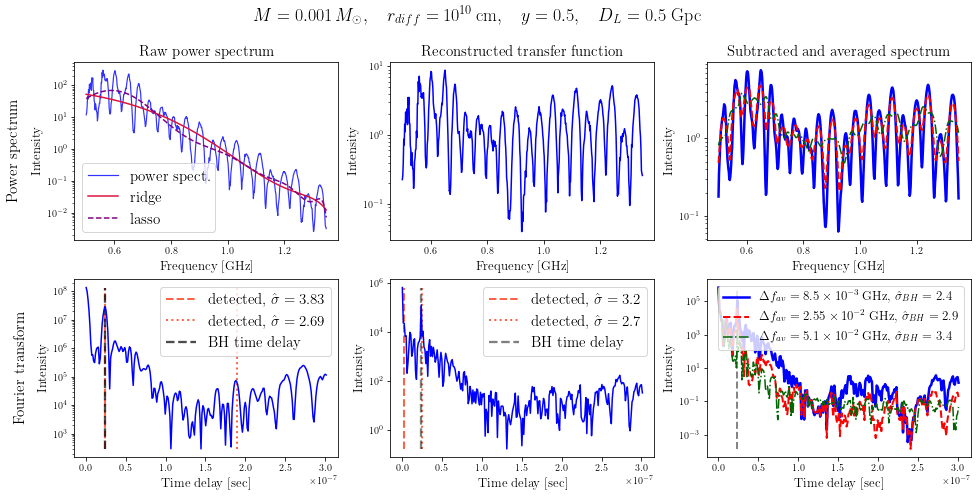

In [18]:
analyze_event(5, events, metadata,smearing = [5, 15, 30]) 

You can change the fitting parameters to see how does the statistical measure change. Results are generally stable with respect to sane variations of the fitting strategies. 

Start event analysis
M = 0.001 solar masses, log(rdiff) = 10.0 cm
The true time delay is 2.3571626611968798e-08 seconds


(3.7404969109289894,
 0.012345679012446223,
 2.5321847211897195,
 0.03614457831334911,
 [0, 2.752671854806466, 3.3730635777619855],
 [100, 0.03614457831334911, 0.05882352941185665],
 0.001,
 10)

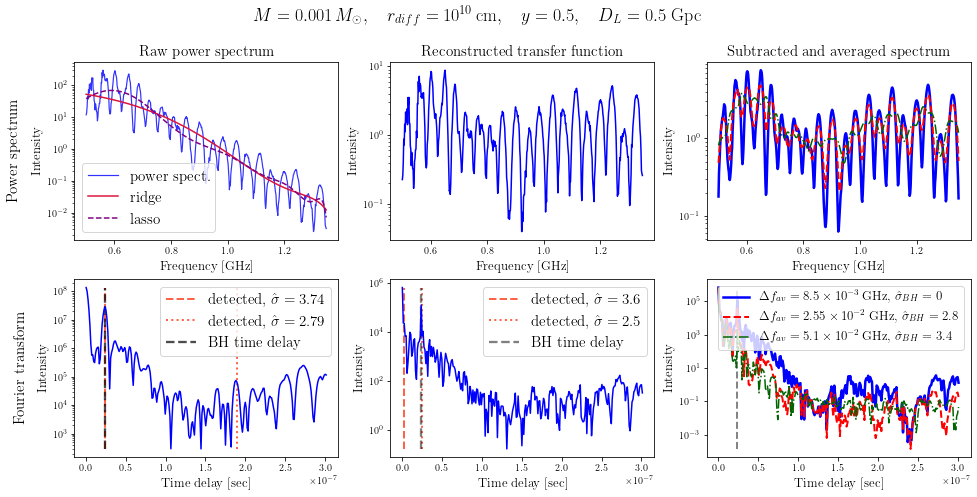

In [24]:
analyze_event(5, events, metadata,smearing = [5, 15, 30], a_input = [1e-12]) 

## Compare three events

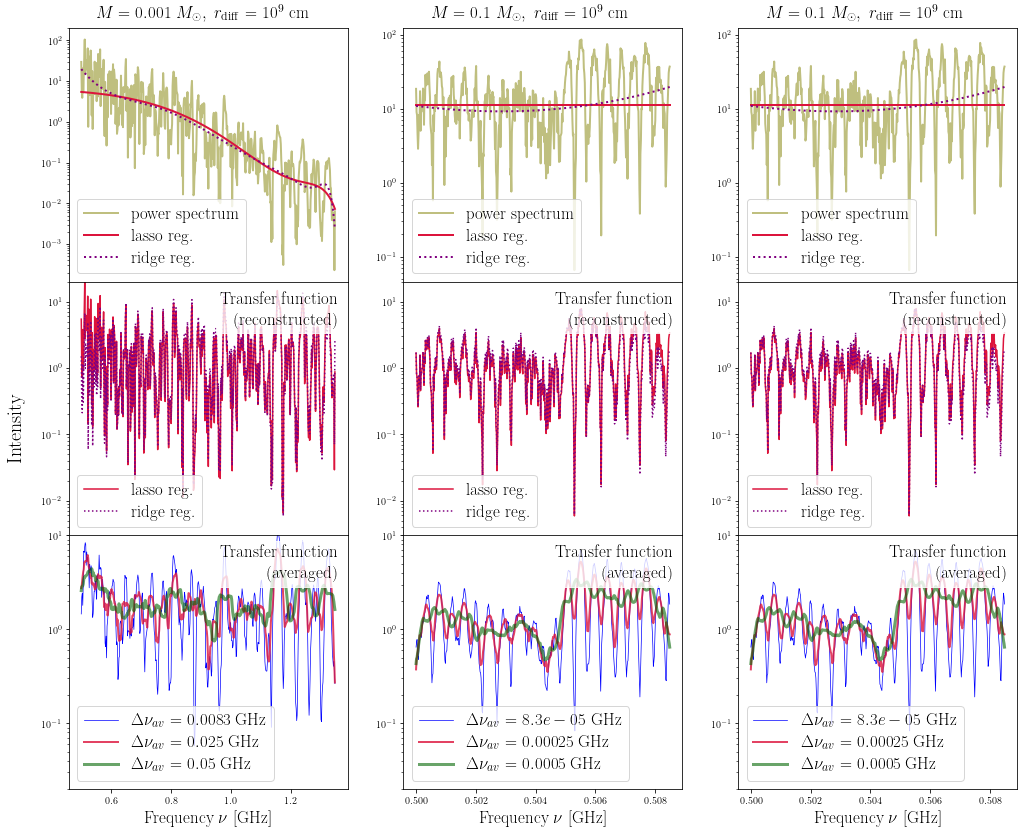

In [20]:
compare_three_powers({'eventfile': events, 'num': 0, 'metadatafile': metadata}, {'eventfile': events, 'num': 2, 'metadatafile': metadata}, 
                     {'eventfile': events, 'num': 2, 'metadatafile': metadata})

Finally, compare the Fourier transforms.

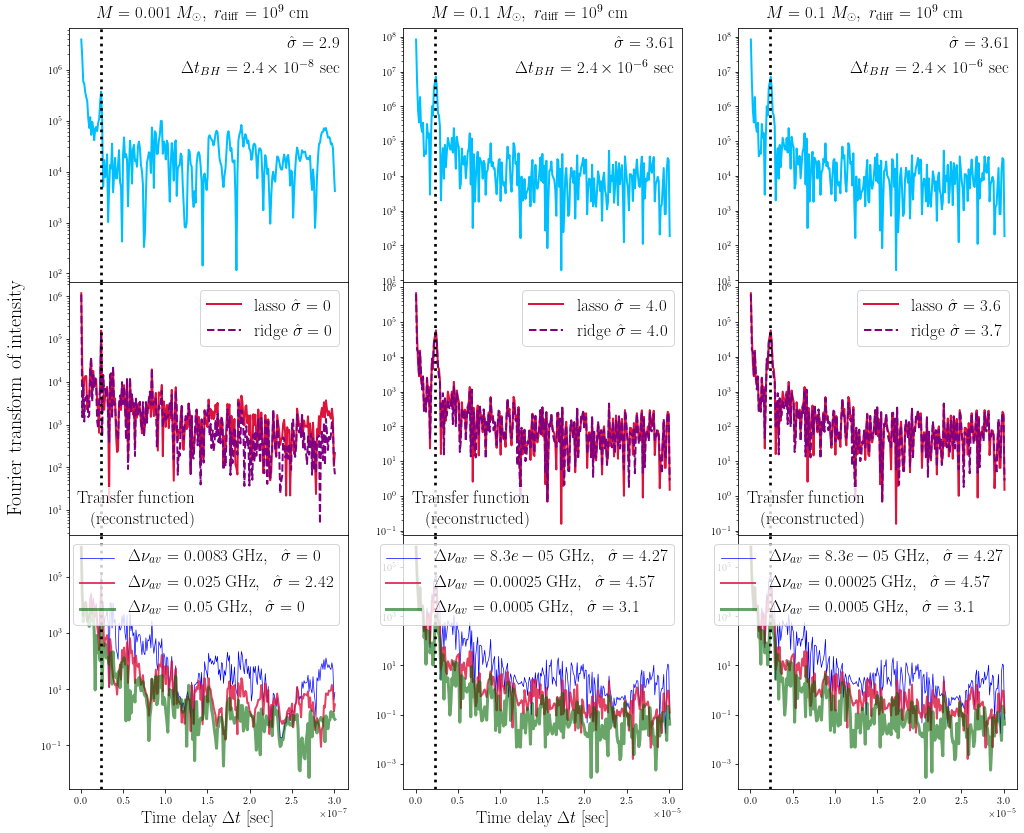

In [22]:
compare_three_ffts({'eventfile': events, 'num': 0, 'metadatafile': metadata}, {'eventfile': events, 'num': 2, 'metadatafile': metadata}, 
                     {'eventfile': events, 'num': 2, 'metadatafile': metadata})